In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from commonfunc.db_handler import DbHandler
from strategies.univariate_strategy import MACDStrategy
from backtest.backtester import Backtester
from dataprocess.tech_indicator import TechnicalIndicators

#### Load data

In [3]:
import os

# using absolute db path
db_file = os.path.join(project_dir, "data\crypto.db") 
db = DbHandler(db_file)

crypto = 'SOL'
crypto_lower = 'sol'

# query price data
query = f"SELECT * FROM {crypto_lower}_hourly order by time" 
df = db.read_from_db(query)

# convert dt columns types to datetime
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35901 entries, 0 to 35900
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   time        35901 non-null  int64                           
 1   utc_dt      35901 non-null  datetime64[ns, UTC]             
 2   nyc_dt      35901 non-null  datetime64[ns, America/New_York]
 3   high        35901 non-null  float64                         
 4   low         35901 non-null  float64                         
 5   open        35901 non-null  float64                         
 6   close       35901 non-null  float64                         
 7   volumefrom  35901 non-null  float64                         
 8   volumeto    35901 non-null  float64                         
 9   avg         35901 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), datetime64[ns, UTC](1), float64(7), int64(1)
memory us

#### Visualize price trend

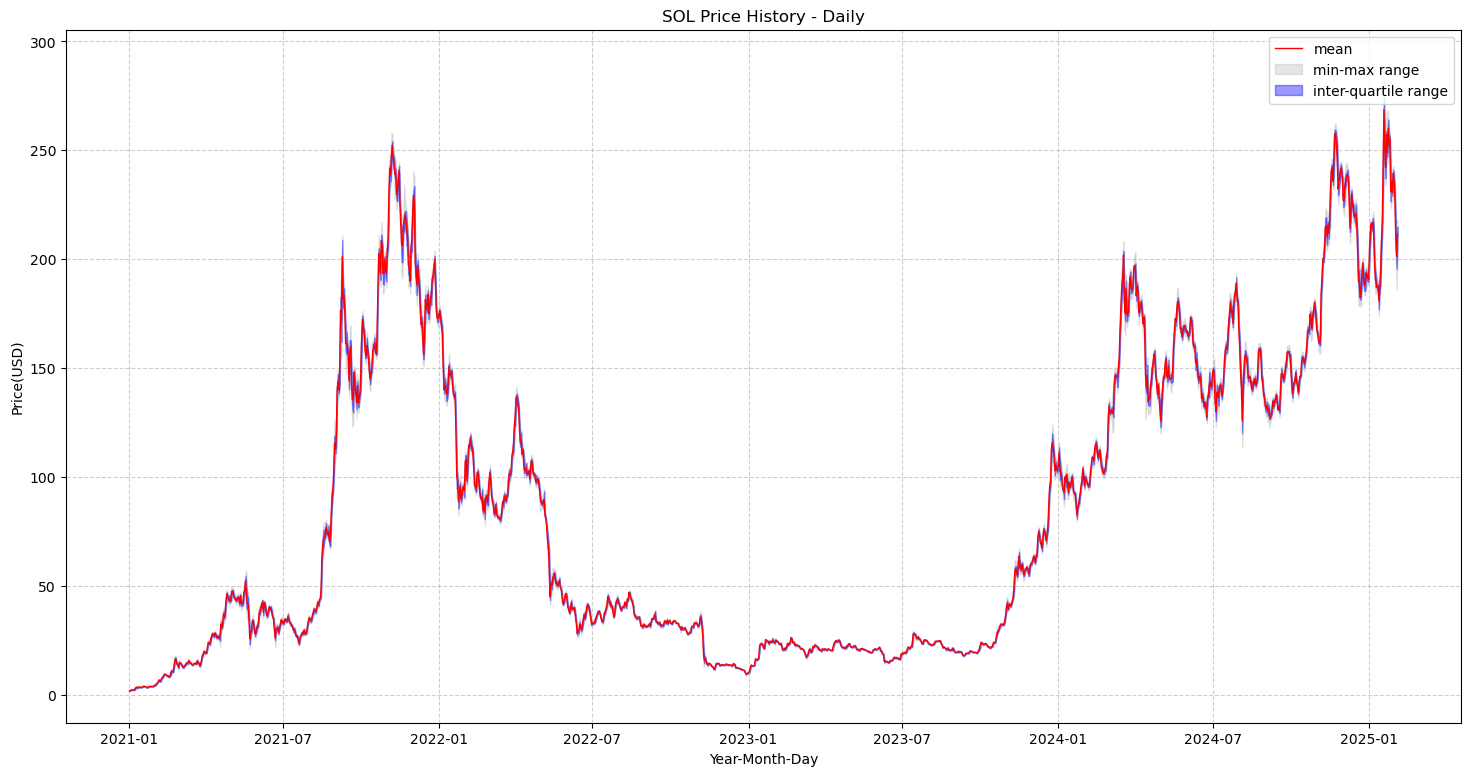

In [4]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month/day
df['year'] = df['utc_dt'].dt.year
df['month'] = df['utc_dt'].dt.month
df['day'] = df['utc_dt'].dt.day
res = df.groupby(['year','month','day'])['avg'].describe().reset_index()
res['ymd'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-' + res['day'].astype(str))

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ymd'],res['mean'],'r-',label='mean',linewidth=1)
# range
plt.fill_between(res['ymd'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ymd'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title(f'{crypto} Price History - Daily')
plt.xlabel('Year-Month-Day')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

#### Compute Tech Indicators

In [5]:
ti = TechnicalIndicators(df.copy())
df_all = ti.compute_all_indicators()
df_all.tail()

,time,utc_dt,nyc_dt,high,low,open,close,volumefrom,volumeto,avg,year,month,day,sma_24,sma_72,ema_24,ema_72,bollinger_upper_24,bollinger_lower_24,atr_14,rsi_14,macd,macd_signal,stoch_osc_14,stoch_rsi_14,cci_20,adx_14,plus_di_14,minus_di_14
35896,1738684800,2025-02-04 16:00:00+00:00,2025-02-04 11:00:00-05:00,217.99,214.61,215.82,214.66,121401.83,26296274.47,216.605256,2025,2,4,211.792083,208.224861,209.991985,211.593593,221.385273,202.198894,4.540000,48.070940,1.539048,1.105109,79.003783,31.541839,39.967600,16.772378,25.005407,17.822199
35897,1738688400,2025-02-04 17:00:00+00:00,2025-02-04 12:00:00-05:00,216.98,212.46,214.66,213.97,101947.81,21850383.41,214.329110,2025,2,4,212.076667,208.040972,210.310227,211.658701,221.497514,202.655819,4.687143,47.392638,1.632341,1.210555,74.653216,37.575844,29.497742,7.618553,22.490386,19.306099
35898,1738692000,2025-02-04 18:00:00+00:00,2025-02-04 13:00:00-05:00,214.75,211.65,213.97,214.59,86194.96,18379885.46,213.236197,2025,2,4,212.176667,207.903611,210.652608,211.739010,221.653321,202.700012,4.653571,52.396479,1.736291,1.315702,78.562421,100.000000,25.122974,4.301264,21.034589,19.299705
35899,1738695600,2025-02-04 19:00:00+00:00,2025-02-04 14:00:00-05:00,218.47,208.44,214.59,208.44,219509.51,47171427.23,214.894686,2025,2,4,211.882083,207.719167,210.475600,211.648626,221.365790,202.398377,4.557143,57.722701,1.307347,1.314031,36.599241,100.000000,4.440980,4.977667,25.776137,23.331712
35900,1738699200,2025-02-04 20:00:00+00:00,2025-02-04 15:00:00-05:00,210.39,205.40,208.44,206.91,139833.78,29046361.60,207.720635,2025,2,4,211.677917,207.559861,210.190352,211.518801,221.376639,201.979194,4.662143,50.224551,0.834331,1.218091,26.927939,66.421959,-57.261649,4.953967,23.395924,25.834798


#### Instantiate and Generate signals with a strategy

In [6]:
macd_strategy = MACDStrategy(data = df_all)
df_macd = macd_strategy.generate_signals()
df_macd.tail()

,time,utc_dt,nyc_dt,high,low,open,close,volumefrom,volumeto,avg,year,month,day,sma_24,sma_72,ema_24,ema_72,bollinger_upper_24,bollinger_lower_24,atr_14,rsi_14,macd,macd_signal,stoch_osc_14,stoch_rsi_14,cci_20,adx_14,plus_di_14,minus_di_14,signal
35896,1738684800,2025-02-04 16:00:00+00:00,2025-02-04 11:00:00-05:00,217.99,214.61,215.82,214.66,121401.83,26296274.47,216.605256,2025,2,4,211.792083,208.224861,209.991985,211.593593,221.385273,202.198894,4.540000,48.070940,1.539048,1.105109,79.003783,31.541839,39.967600,16.772378,25.005407,17.822199,1
35897,1738688400,2025-02-04 17:00:00+00:00,2025-02-04 12:00:00-05:00,216.98,212.46,214.66,213.97,101947.81,21850383.41,214.329110,2025,2,4,212.076667,208.040972,210.310227,211.658701,221.497514,202.655819,4.687143,47.392638,1.632341,1.210555,74.653216,37.575844,29.497742,7.618553,22.490386,19.306099,1
35898,1738692000,2025-02-04 18:00:00+00:00,2025-02-04 13:00:00-05:00,214.75,211.65,213.97,214.59,86194.96,18379885.46,213.236197,2025,2,4,212.176667,207.903611,210.652608,211.739010,221.653321,202.700012,4.653571,52.396479,1.736291,1.315702,78.562421,100.000000,25.122974,4.301264,21.034589,19.299705,1
35899,1738695600,2025-02-04 19:00:00+00:00,2025-02-04 14:00:00-05:00,218.47,208.44,214.59,208.44,219509.51,47171427.23,214.894686,2025,2,4,211.882083,207.719167,210.475600,211.648626,221.365790,202.398377,4.557143,57.722701,1.307347,1.314031,36.599241,100.000000,4.440980,4.977667,25.776137,23.331712,-1
35900,1738699200,2025-02-04 20:00:00+00:00,2025-02-04 15:00:00-05:00,210.39,205.40,208.44,206.91,139833.78,29046361.60,207.720635,2025,2,4,211.677917,207.559861,210.190352,211.518801,221.376639,201.979194,4.662143,50.224551,0.834331,1.218091,26.927939,66.421959,-57.261649,4.953967,23.395924,25.834798,-1


#### Run backtest

In [12]:
backtest_macd = Backtester(
    data=df_macd[df_macd['year']>=2022],
    initial_capital=10000,
    stop_loss=0.04,
    take_profit=0.12,
    position_sizing_func=lambda cap: cap*1
)

results = backtest_macd.run_backtest()
report = backtest_macd.get_report()

In [13]:
report

{'Initial Capital': 10000,
 'Final Capital': 17593.426824438397,
 'Total Profit': 7593.426824438397,
 'ROI (%)': 75.93426824438396,
 'Number of Trades': 2168,
 'Max Drawdown': -1.0,
 'Trade Details': [{'index': 2,
   'time': Timestamp('2021-12-31 21:00:00-0500', tz='America/New_York'),
   'type': 'buy',
   'units': 57.9139398853304,
   'price': 172.67,
   'capital_before': 10000,
   'capital_after': 0},
  {'index': 29,
   'time': Timestamp('2022-01-02 00:00:00-0500', tz='America/New_York'),
   'type': 'sell',
   'units': 57.9139398853304,
   'price': 176.67,
   'capital_before': 0.0,
   'capital_after': 10231.655759541321},
  {'index': 41,
   'time': Timestamp('2022-01-02 12:00:00-0500', tz='America/New_York'),
   'type': 'buy',
   'units': 57.55558170411948,
   'price': 177.77,
   'capital_before': 10231.655759541321,
   'capital_after': 0.0},
  {'index': 42,
   'time': Timestamp('2022-01-02 13:00:00-0500', tz='America/New_York'),
   'type': 'sell',
   'units': 57.55558170411948,
   '

C:\Users\elisa\AppData\Local\Temp\ipykernel_42468\1184947649.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_macd['quarter'] = df_macd['utc_dt'].dt.to_period('Q')


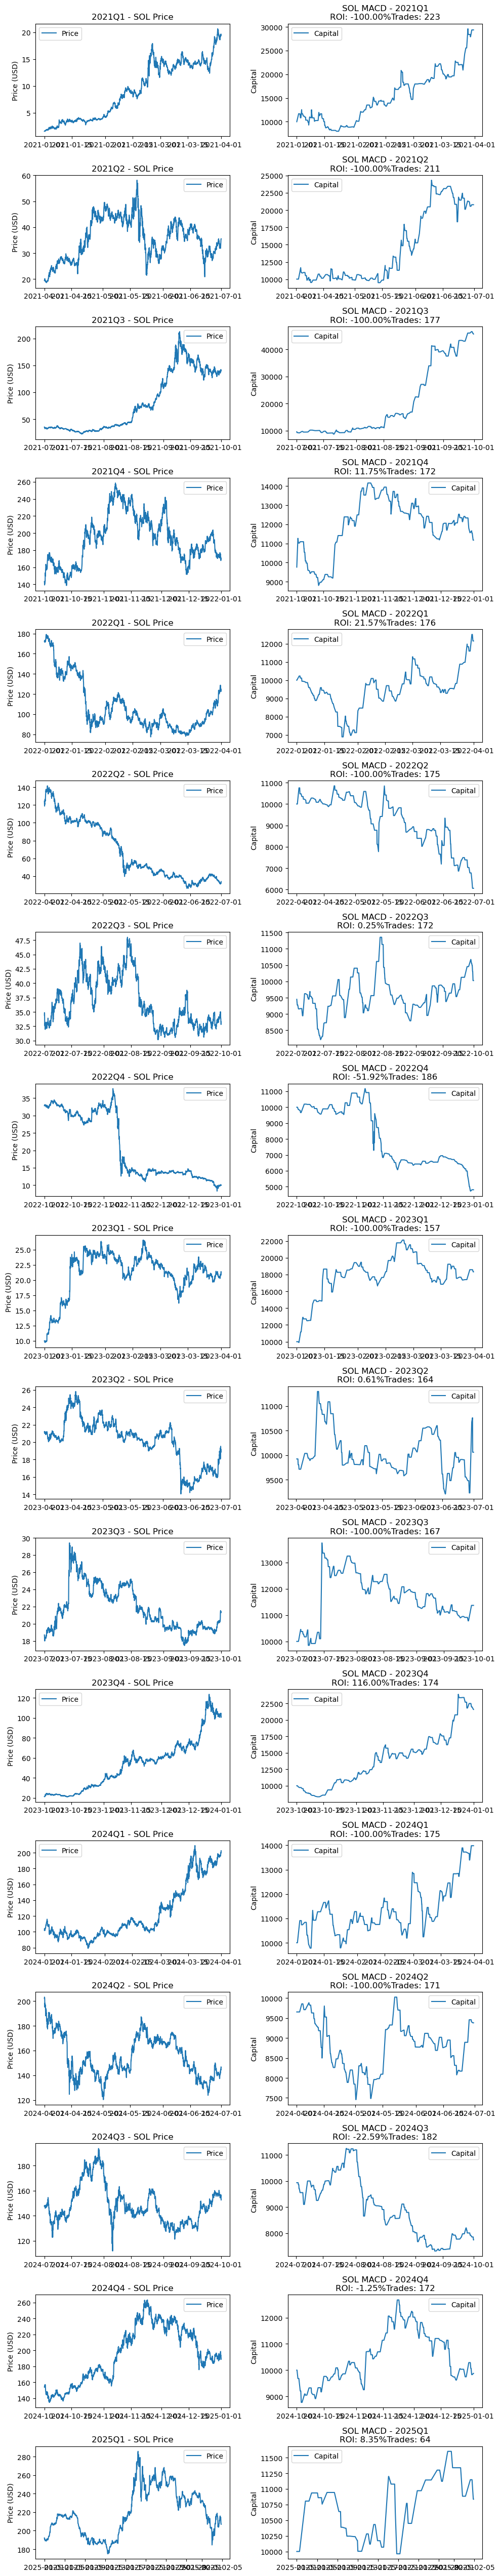

In [25]:
df_macd['quarter'] = df_macd['utc_dt'].dt.to_period('Q')

unique_quarters = df_macd['quarter'].unique()
unique_quarters = sorted(unique_quarters)  # ensure ascending order

num_quarters = len(unique_quarters)
fig, axes = plt.subplots(num_quarters, 2, figsize=(10, 3 * num_quarters), sharex=False)

for i, quarter in enumerate(unique_quarters):
    ax_price = axes[i][0]
    ax_capital = axes[i][1]

    df_q = df_macd[df_macd['quarter']==quarter]

    ax_price.plot(df_q['utc_dt'],df_q['close'],label='Price')
    ax_price.set_ylabel('Price (USD)')
    ax_price.set_title(f"{quarter} - {crypto} Price")
    ax_price.legend()

    macd_strat = MACDStrategy(data=df_q)
    df_signals = macd_strat.generate_signals()

    backtest = Backtester(
        data=df_signals,
        initial_capital=10000,
        stop_loss=0.04,
        take_profit=0.15,
        position_sizing_func=lambda cap: cap*1
    )

    result_df = backtest.run_backtest()
    report = backtest.get_report()

    ax_capital.plot(result_df[result_df['capital']>0]['utc_dt'],result_df[result_df['capital']>0]['capital'],label='Capital')

    ax_capital.set_title(
        f"{crypto} MACD - {quarter}\n"
        f"ROI: {report['ROI (%)']:.2f}%"
        f"Trades: {report['Number of Trades']}"
    )

    ax_capital.set_ylabel("Capital")
    ax_capital.legend()

plt.tight_layout()
plt.show()
